In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community as nxcm
from sklearn.cluster import KMeans
from networkx import edge_betweenness_centrality as betweenness
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram

In [ ]:
G = nx.read_gml('karate.gml', label = 'id')
H = nx.read_gml('dolphins.gml', label = 'id')
fh=open("jazz.net", "rb")
I = nx.read_weighted_edgelist(fh)

# Algorithms applied on Karate Club Graph. 

Applied on rest of the Graphs in the Q4.ipynb.

In [ ]:
# Program for Girvan-Newman
def most_central_edge(G):
    centrality = betweenness(G, weight="weight") 
    return max(centrality, key=centrality.get) #For finding edge betweenness and returning max value 

comp_GN = nxcm.girvan_newman(G, most_valuable_edge=most_central_edge)
communities = list(nx.community.girvan_newman(G)) 

In [ ]:
# Building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# Turning this dictionary to the desired format
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# Recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# Making a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# Merge Height
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range



{'icoord': [[25.0, 25.0, 35.0, 35.0], [15.0, 15.0, 30.0, 30.0], [5.0, 5.0, 22.5, 22.5], [13.75, 13.75, 45.0, 45.0], [29.375, 29.375, 55.0, 55.0], [42.1875, 42.1875, 65.0, 65.0], [53.59375, 53.59375, 75.0, 75.0], [64.296875, 64.296875, 85.0, 85.0], [74.6484375, 74.6484375, 95.0, 95.0], [105.0, 105.0, 115.0, 115.0], [135.0, 135.0, 145.0, 145.0], [125.0, 125.0, 140.0, 140.0], [110.0, 110.0, 132.5, 132.5], [84.82421875, 84.82421875, 121.25, 121.25], [155.0, 155.0, 165.0, 165.0], [160.0, 160.0, 175.0, 175.0], [195.0, 195.0, 205.0, 205.0], [185.0, 185.0, 200.0, 200.0], [167.5, 167.5, 192.5, 192.5], [245.0, 245.0, 255.0, 255.0], [235.0, 235.0, 250.0, 250.0], [225.0, 225.0, 242.5, 242.5], [233.75, 233.75, 265.0, 265.0], [215.0, 215.0, 249.375, 249.375], [232.1875, 232.1875, 275.0, 275.0], [253.59375, 253.59375, 285.0, 285.0], [269.296875, 269.296875, 295.0, 295.0], [282.1484375, 282.1484375, 305.0, 305.0], [293.57421875, 293.57421875, 315.0, 315.0], [304.287109375, 304.287109375, 325.0, 325.0]

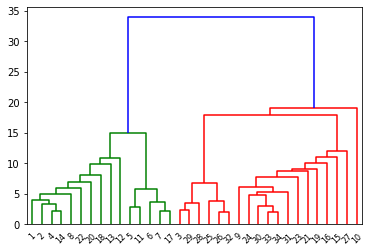

In [ ]:
# Create new Digraph for scipy dendrogram
M           = nx.DiGraph(node_id_to_children)
nodes       = M.nodes()
leaves      = set( n for n in nodes if M.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if M.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1


plt.figure()
x=dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
print(x)
plt.show()

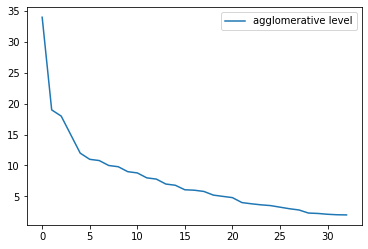

In [ ]:
#Inverse Skree Test helps to find natural number of clusters/communities
cluster_number = []
agg_level = []


for i in range(len(x['dcoord'])):
    cluster_number.append(i)
    agg_level.append(max(x['dcoord'][i]))
    
agg_level = sorted(agg_level)
cluster_number = sorted(cluster_number,reverse=True)

plt.plot(cluster_number,agg_level,label='agglomerative level')
plt.legend()

In [ ]:
#As we can see from the dendrogram that the highest differnce between levels happens between the initial link. 
#So if we cut from there we get 2 natural clusters. 
#Same is shown in an inverse scree test.

In [ ]:
print("Communities of Karate Club Network through Girvan-Newman")
first_division=next(comp_GN);
print(sorted(first_division))
#print("-------------------------------------------------------")

Communities of Karate Club Network through Girvan-Newman
[{1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}, {3, 9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}]


In [ ]:
# Program for Modularity Maximization
comp_MM = list(nxcm.modularity_max.greedy_modularity_communities(G))
for i in range (0,len(comp_MM)):
  print(sorted(comp_MM[i]))


[9, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[2, 3, 4, 8, 10, 13, 14, 18, 22]
[1, 5, 6, 7, 11, 12, 17, 20]


In [ ]:
# Program for Spectral Clustering
K=len(first_division)
L = nx.laplacian_matrix(G) #Generate Laplacian Matrix
e, v = np.linalg.eig(L.todense()) #Generate Eigen Values
idx = np.argsort(e) 
e = e[idx]
v = v[:,idx]
v=v[:,1]
kmeans = KMeans(n_clusters=K, random_state=0).fit(v.reshape(-1,1)) 
ls = np.abs(kmeans.labels_)

comp_SC=[]
for i in range(0,K):
  print(np.where(ls==i)[0]+1)


for i in range(0,K): # Converting output of k-means to list format
  temp=[]
  for j in range(0,len(ls)):
    if(ls[j]==i):
      temp.append(j+1)
  comp_SC.append(temp)

print(comp_SC)

[ 2  3  4  8  9 10 14 15 16 19 20 21 23 24 25 26 27 28 29 30 31 32 33 34]
[ 1  5  6  7 11 12 13 17 18 22]
[[2, 3, 4, 8, 9, 10, 14, 15, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], [1, 5, 6, 7, 11, 12, 13, 17, 18, 22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
